In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from copy import deepcopy
import os
import os.path as op
import sys
from matplotlib import pyplot as plt
%matplotlib

loc = 'workstation'
if loc == 'laptop':
    #eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/student_projects/EffortDifficulty/analysis/tools'
    eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/tools'
    wd         = '/Users/sammichekroud/Desktop/postdoc/wmconfidence' #working on confidence data, but in postdoc dir
elif loc == 'workstation':
    eyefuncdir = 'C:/Users/sammirc/Desktop/postdoc/tools/'
    wd         =  'C:/Users/sammirc/Desktop/postdoc/tuningcurves'
    funcdir    = op.join(wd, 'analysis', 'tools')
    sys.path.insert(0, funcdir)
os.chdir(wd)
sys.path.insert(0, eyefuncdir)
from funcs import clusterperm_test


bdir   = op.join(wd, 'data', 'datafiles')

subs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,     11, 12, 13, 14, 15, 16, 17, 18,     20, 21, 22,     24, 25, 26])
# subs = np.array([         4, 5, 6, 7, 8, 9,             13, 14, 15,     17,         20, 21, 22,     24, 25, 26])
nsubs = subs.size

#set some params here
modeltimes = np.round(np.load(op.join(wd, 'data', 'tuningcurves', 'times.npy')), 2)
eegtimes   = np.round(np.load(op.join(wd, 'data', 'glms', 'eeg', 'glm2', 'eeg_times.npy')), 2)
regnames   = np.load(op.join(wd, 'data', 'glms', 'eeg', 'glm2', 'regressor_names.npy'))

nparams = regnames.size
#ppts x tuning curve timepoints x regressors x1

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
b = np.zeros(shape = [nsubs, nparams, modeltimes.size, eegtimes.size]) * np.nan
t = np.zeros(shape = [nsubs, nparams, modeltimes.size, eegtimes.size]) * np.nan

use_b = True
if use_b:
    paramind = 0
    addtext = 'modelAmplitudeBeta'
elif not use_b:
    paramind = 1
    addtext = 'modelAmplitudeTvalue'
fittype = 'glm'
if fittype == 'opt':
    fittext = 'b1optfit'
elif fittype == 'glm':
    fittext = 'b1glmfit'

#use a model that predicts log-transformed power (10*log10) so looking at decibels
logdata = True
if logdata:
    logtxt = '_logpower'
else:
    logtxt = ''

# use the output froma  model that uses lightly smoothed amplitude estimates across time? reduces some noise at single trial level
smoothamp = True
if smoothamp:
    #smoothed amplitude estimate lightly over time   
    amptxt = '_smoothamp'
elif not smoothamp:
    amptxt = ''

subcount = -1
for sub in subs:
    subcount += 1
    ib = np.load(op.join(wd, 'data', 'glms', 'eeg', 'glm2', f'wmc_s{sub:02d}_glm2{logtxt}_betas_{fittext}_{addtext}{amptxt}.npy')) #has shape: tuning curve time x regressors x eyetracker time
    it = np.load(op.join(wd, 'data', 'glms', 'eeg', 'glm2', f'wmc_s{sub:02d}_glm2{logtxt}_tvalues_{fittext}_{addtext}{amptxt}.npy'))
    b[subcount] = ib.copy()
    t[subcount] = it.copy()
bm = np.nanmean(b, axis=0) #average across participants
tm = np.nanmean(t, axis=0)

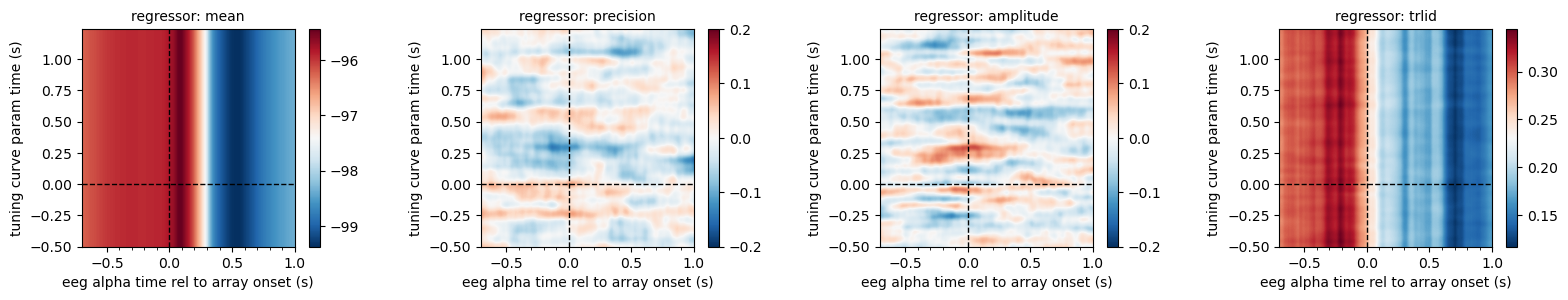

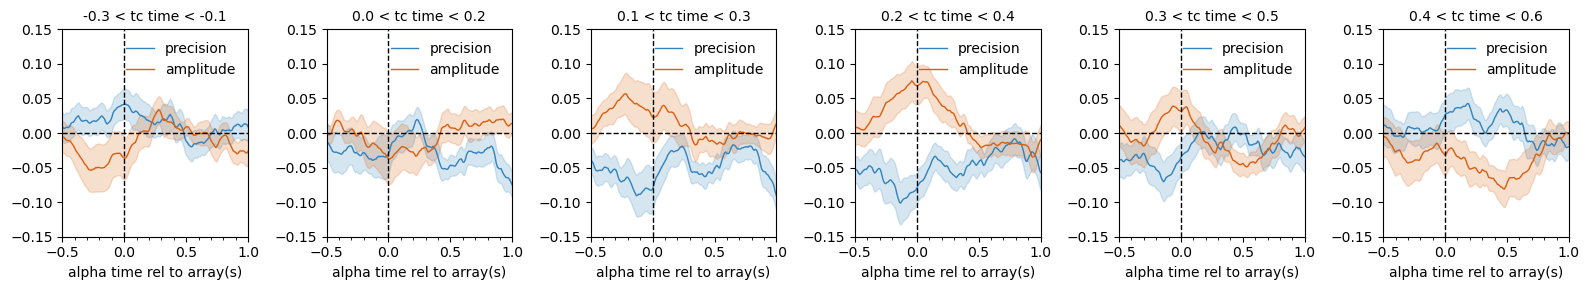

In [3]:
check_b = True
if check_b:
    dat = bm.copy()
    d = b.copy()
else:
    dat = tm.copy()
    d = t.copy()
fig = plt.figure(figsize = [16, 3])
for iparam in range(nparams):
    if iparam in [0, 3]:
        if check_b:
            vmin, vmax = None, None
        else:
            vmin, vmax = None, None
    else:
        if check_b:
            vmin, vmax = -3e-11, 3e-11 #for non log transformed power
            vmin, vmax = -0.2, 0.2 # for log transformed power
        else:
            vmin, vmax = -1, 1 #for non log-transformed power
            vmin, vmax = -1.5, 1.5 #for log transformed power
    ax = fig.add_subplot(1, 4, iparam+1)
    plot = ax.imshow(dat[iparam].squeeze(), aspect= 'equal', interpolation='gaussian', cmap='RdBu_r', origin = 'lower',
                     vmin = vmin, vmax = vmax, 
                     extent = [eegtimes.min(), eegtimes.max(), modeltimes.min(), modeltimes.max()])
    ax.set_title(f'regressor: {regnames[iparam]}', fontsize = 10)
    ax.axvline(0, ls = 'dashed', color = 'k', lw = 1)
    ax.axhline(0, ls = 'dashed', color = 'k', lw = 1)
    ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
    ax.set_xlabel('eeg alpha time rel to array onset (s)')
    ax.set_ylabel('tuning curve param time (s)')
    fig.colorbar(plot)
fig.tight_layout()

mstarts = [-0.3, 0.0, 0.1, 0.2, 0.3, 0.4]
mends   = [-0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e', '#756bb1']
fig = plt.figure(figsize = [16, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    # print(iplot, istart, iend)
    ax = fig.add_subplot(1, nplots, iplot+1)
    tinds = np.logical_and(modeltimes >= istart, modeltimes <= iend)
    plotd = d[:, :, tinds].mean(axis=2) #average across the timewindow
    plotm = plotd.mean(axis=0) #average across participants
    plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

    #loop over regressors
    for ireg in range(2):
    # for ireg in range(3):
        ax.plot(eegtimes, plotm[ireg+1], label = regnames[ireg+1], lw = 1, c = cols[ireg])
        ax.fill_between(eegtimes,
                        np.add(plotm[ireg+1], plotsem[ireg+1]),
                        np.subtract(plotm[ireg+1], plotsem[ireg+1]),
                        edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart} < tc time < {iend}', fontsize = 10)
    
    if check_b:
        ax.set_ylim([-4e-11, 4e-11]) #for non log transformed power
        ax.set_ylim([-0.15, 0.15]) #for log transformed power
        # ax.set_ylim([-0.15, 0.5])
    elif not check_b:
        ax.set_ylim([-1, 1])
    ax.set_xlim([-0.5, 0.7])
    ax.set_xlabel(f'alpha time rel to array(s)', fontsize = 10)
    ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
    ax.legend(loc = 'upper right', frameon=False)
fig.tight_layout()

<font color='red'>

the model visualised here contains regressors for the tuning curve precision, amplitude, and a z-scored regressor for trial number that should account for linear changes in alpha power over the task. Overall the regressor for trial number is positive, suggesting that there is indeed an overall increase in baseline alpha power across the task. this effect trends to zero after array onset, as variability across trials decreases (due to the induced alpha suppression associated with the visual stimuli).

it looks like baseline alpha power (pre-onset of the array) is negatively associated with tuning curve precision throughout the active processing period. we can visualise this next, and run some cluster permutation stats to see if baseline alpha power is significantly related to modelled tuning curve parameters

stat_fun(H1): min=-2.7250233012210923 max=1.477454568041715
Running initial clustering …
Found 3 clusters


C:\Users\sammirc\anaconda3\envs\mne\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Permuting : 9999/9999 [00:05<00:00, 1699.13it/s]


cluster p-values for precision regressor: [0.0284 0.373  0.1597]
stat_fun(H1): min=-1.6949093594308695 max=2.9708030446857996
Running initial clustering …
Found 0 clusters


C:\Users/sammirc/Desktop/postdoc/tuningcurves\analysis\tools\funcs.py:304: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_1samp_test(data_twin, out_type=out_type, n_permutations = n_permutations, tail = tail, threshold = threshold, n_jobs = n_jobs)


cluster p-values for amplitude regressor: []
stat_fun(H1): min=-2.67562499854943 max=1.6363515229836467
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 9999/9999 [00:00<00:00, 13210.77it/s]

cluster p-values for precision regressor: [0.1116 0.0995 0.1808]
stat_fun(H1): min=-2.3720455362819837 max=2.543261545425854
Running initial clustering …
Found 1 cluster



100%|██████████| Permuting : 9999/9999 [00:00<00:00, 14262.19it/s]


cluster p-values for amplitude regressor: [0.0859]
stat_fun(H1): min=-2.666079906804737 max=1.4567093722061601
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 9999/9999 [00:00<00:00, 14452.01it/s]

cluster p-values for precision regressor: [0.0122 0.1943 0.2046]
stat_fun(H1): min=-2.0306740209874987 max=2.470124008181883


Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 9999/9999 [00:00<00:00, 16027.80it/s]


cluster p-values for amplitude regressor: [0.343]


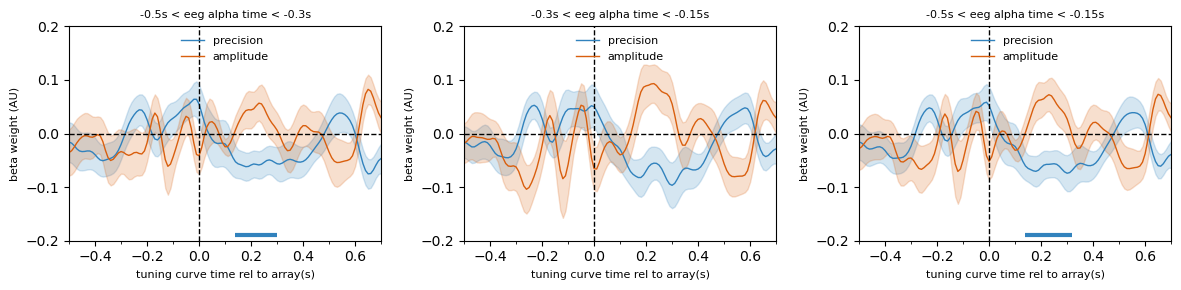

In [4]:
check_b = True

#params for cluster forming
alpha = 0.05
t_thresh = sp.stats.t.ppf(1-alpha, df = nsubs -1)
tmin, tmax = 0, 0.75 #time-window for cluster permutation testing
nperms = 10000

if check_b:
    dat = bm.copy()
    d = b.copy()
else:
    dat = tm.copy()
    d = t.copy()

mstarts = [-0.5, -0.3,  -0.5]
mends   = [-0.3, -0.15, -0.15]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e', '#756bb1']
# labs = ['precision', 'amplitude', 'trialnumber']
labs = regnames[1:]
fig = plt.figure(figsize = [12, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    ax = fig.add_subplot(1, nplots, iplot+1)
    # print(iplot, istart, iend)
    tinds = np.logical_and(eegtimes >= istart, eegtimes <= iend)
    idat = d[:,:,:,tinds].copy().mean(-1)
    for ireg in range(2):
    # for ireg in range(3):
        plotd = d[:,:,:,tinds].mean(-1)
        plotd = plotd[:,ireg+1] #take just the relevant parameter
        plotm = plotd.mean(axis=0) #average across participants
        plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')
    
        ax.plot(modeltimes, plotm, label = labs[ireg], lw = 1, c = cols[ireg])
        ax.fill_between(modeltimes,
                        np.add(plotm, plotsem),
                        np.subtract(plotm, plotsem),
                        edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart}s < eeg alpha time < {iend}s', fontsize = 8)

    #run cluster permutation stats
    for reg in ['precision', 'amplitude']:
        if reg == 'precision':
            icol = '#3182bd'
            ih = -0.19
        else:
            icol = '#d95f0e'
            ih = -0.21
        tv, clu, clupv, _ = clusterperm_test(data = idat,
                                        labels = regnames, of_interest = reg, times = modeltimes,
                                        tmin = tmin, tmax = tmax, out_type = 'indices', n_permutations = nperms,
                                        threshold = -t_thresh, tail = -1,
                                        n_jobs=4)
        clu = [x[0] for x in clu]
        print(f'cluster p-values for {reg} regressor: {clupv}')
        times_twin = modeltimes[np.logical_and(modeltimes>=tmin, modeltimes <= tmax)]
        nclus = len(clu)
        for icluster in range(nclus):
            mask = clu[icluster]
            if clupv[icluster] <= alpha:
                itmin = times_twin[mask[0]]
                itmax = times_twin[mask[-1]]
                ax.hlines(y = ih, xmin = itmin, xmax = itmax, lw = 3, color = icol, alpha = 1)

    
    if check_b:
        ax.set_ylim([-4e-11, 4e-11]) #for non log transformed power
        ax.set_ylim([-0.2, 0.2]) #for log transformed power
        # ax.set_ylim([0.2, 0.5])
    elif not check_b:
        ax.set_ylim([-1.2, 1.2])
    ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
    ax.set_xlim([-0.5, 0.7])
    ax.set_xlabel('tuning curve time rel to array(s)', fontsize = 8)
    ax.set_ylabel('beta weight (AU)', fontsize = 8)
    ax.legend(loc = 'upper center', frameon=False, fontsize=8)
fig.tight_layout()

<font color='red'>

here we can see that some clusters survive permutation testing when looking at the relationship between alpha power and tuning curve parameters - namely, tuning curve precision.

Three baseline periods are chosen: 500-300ms pre-stimulus, 300-0ms pre-stimulus, and 500-150ms prestimulus (this is non-arbitrary as a 300ms window is used for frequency estimation, so 150ms is the last point before there is smearing after stimulus onset).

In all three choices, a significant cluster emerges between ~100-300ms after stimulus onset, where baseline alpha power is negatively related to tuning curve precision. This reflects that **_decreased alpha power_** is associated with **_increased tuning curve precision_**. this survives a two-tailed test, with a cluster forming threshold set at 0.05 for the degrees of freedom in the study (nsubs-1 in the dataset).

No clusters survive permutation testing for the amplitude regressor

<font color='blue'>

next, we can run the exact same pipeline but instead of looking at output beta weights across participants, we can do statistics on the output t-values of the same regression model, which takes into account single-subject variability in the effect.

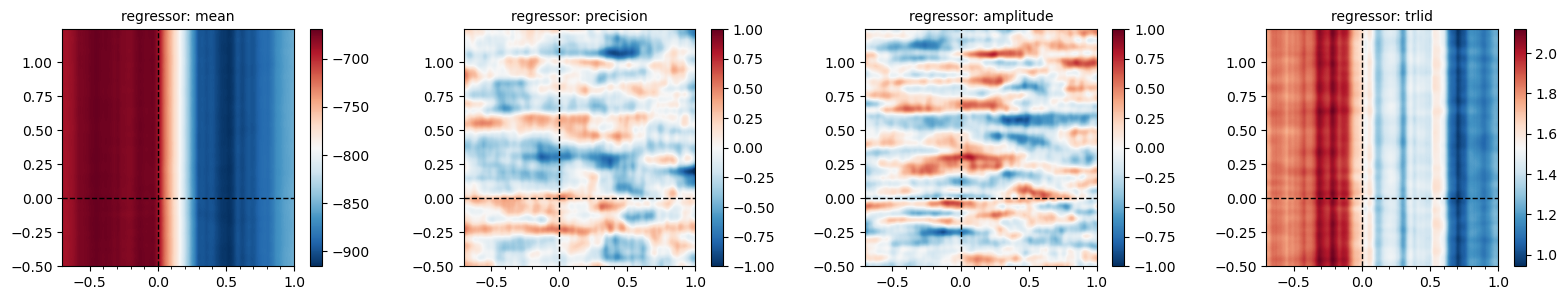

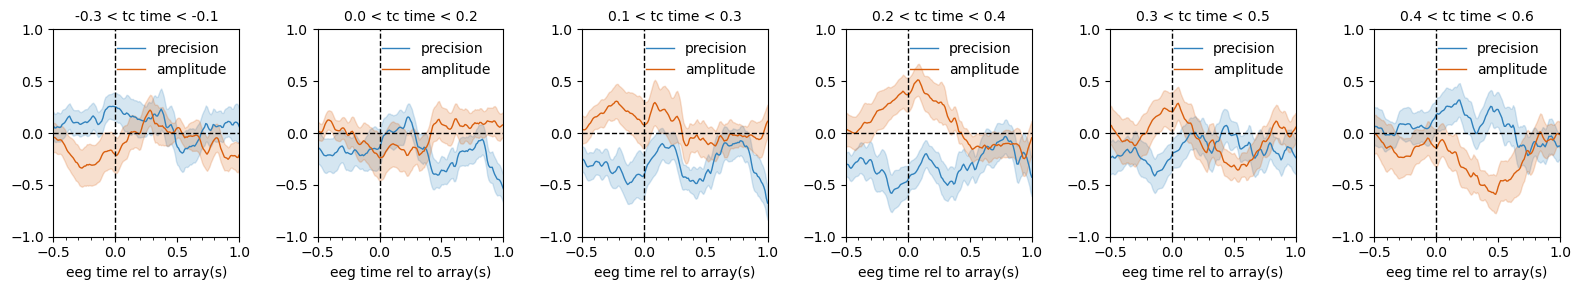

In [5]:
check_b = False
if check_b:
    dat = bm.copy()
    d = b.copy()
else:
    dat = tm.copy()
    d = t.copy()
fig = plt.figure(figsize = [16, 3])
for iparam in range(nparams):
    if iparam in [0,3]:
        if check_b:
            vmin, vmax = None, None
        else:
            vmin, vmax = None, None
    else:
        if check_b:
            vmin, vmax = -3e-11, 3e-11 #for non log transformed power
            vmin, vmax = -0.2, 0.2 # for log transformed power
        else:
            vmin, vmax = -1, 1 #for non log-transformed power
            vmin, vmax = -1, 1#for log transformed power
    ax = fig.add_subplot(1, 4, iparam+1)
    plot = ax.imshow(dat[iparam].squeeze(), aspect= 'equal', interpolation='gaussian', cmap='RdBu_r', origin = 'lower',
                     vmin = vmin, vmax = vmax, 
                     extent = [eegtimes.min(), eegtimes.max(), modeltimes.min(), modeltimes.max()])
    ax.set_title(f'regressor: {regnames[iparam]}', fontsize = 10)
    ax.axvline(0, ls = 'dashed', color = 'k', lw = 1)
    ax.axhline(0, ls = 'dashed', color = 'k', lw = 1)
    ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
    fig.colorbar(plot)
fig.tight_layout()

mstarts = [-0.3, 0.0, 0.1, 0.2, 0.3, 0.4]
mends   = [-0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e', '#756bb1']
fig = plt.figure(figsize = [16, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    # print(iplot, istart, iend)
    ax = fig.add_subplot(1, nplots, iplot+1)
    tinds = np.logical_and(modeltimes >= istart, modeltimes <= iend)
    plotd = d[:, :, tinds].mean(axis=2) #average across the timewindow
    plotm = plotd.mean(axis=0) #average across participants
    plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

    #loop over regressors
    for ireg in range(2):
    # for ireg in range(3):
        ax.plot(eegtimes, plotm[ireg+1], label = regnames[ireg+1], lw = 1, c = cols[ireg])
        ax.fill_between(eegtimes,
                        np.add(plotm[ireg+1], plotsem[ireg+1]),
                        np.subtract(plotm[ireg+1], plotsem[ireg+1]),
                        edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart} < tc time < {iend}', fontsize = 10)

    if check_b:
        ax.set_ylim([-4e-11, 4e-11]) #for non log transformed power
        ax.set_ylim([-0.2, 0.2]) #for log transformed power
    elif not check_b:
        ax.set_ylim([-1, 1])
    ax.set_xlim([-0.5, 0.7])
    ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
    ax.set_xlabel('eeg time rel to array(s)', fontsize = 10)
    ax.legend(loc = 'upper right', frameon=False)
fig.tight_layout()

stat_fun(H1): min=-2.6080386913284554 max=1.2571197694718406
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 9999/9999 [00:00<00:00, 16589.83it/s]


cluster p-values for precision regressor: [0.098  0.4734 0.144 ]
stat_fun(H1): min=-1.5839362285085086 max=3.200265123112932
Running initial clustering …
Found 0 clusters


C:\Users/sammirc/Desktop/postdoc/tuningcurves\analysis\tools\funcs.py:304: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_1samp_test(data_twin, out_type=out_type, n_permutations = n_permutations, tail = tail, threshold = threshold, n_jobs = n_jobs)


cluster p-values for amplitude regressor: []
stat_fun(H1): min=-2.7509483326362076 max=2.0417459376902136
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 9999/9999 [00:00<00:00, 16679.15it/s]


cluster p-values for precision regressor: [0.3278 0.0222 0.3811]
stat_fun(H1): min=-2.181783532181122 max=2.155627043948203
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 9999/9999 [00:00<00:00, 15759.17it/s]


cluster p-values for amplitude regressor: [0.1165]
stat_fun(H1): min=-2.445681737956797 max=1.6760312487823046
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 9999/9999 [00:00<00:00, 16091.28it/s]

cluster p-values for precision regressor: [0.0658 0.3018 0.2858 0.2247]
stat_fun(H1): min=-2.004518130751343 max=2.568830211973988
Running initial clustering …
Found 1 cluster



100%|██████████| Permuting : 9999/9999 [00:00<00:00, 14404.70it/s]


cluster p-values for amplitude regressor: [0.4228]


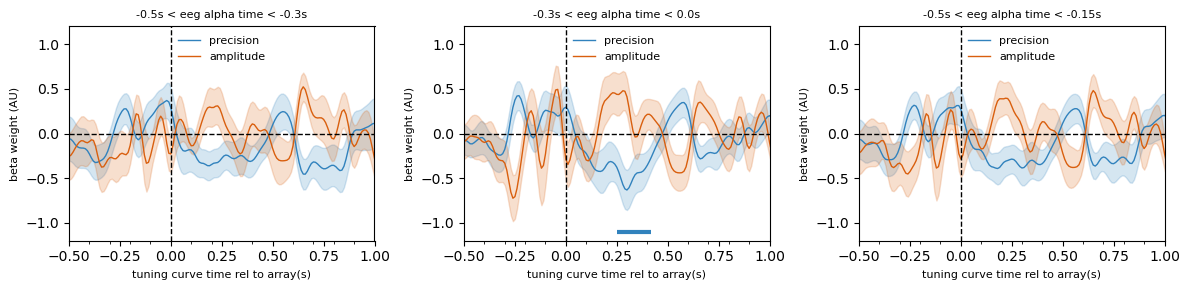

In [6]:
check_b = False
if check_b:
    dat = bm.copy()
    d = b.copy()
else:
    dat = tm.copy()
    d = t.copy()

#params for cluster forming
alpha = 0.05
t_thresh = sp.stats.t.ppf(1-alpha, df = nsubs-1)
tmin, tmax = 0, 0.75 #time-window for cluster permutation testing
nperms = 10000

mstarts = [-0.5, -0.3, -0.5]
mends   = [-0.3,  0.0, -0.15]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e', '#756bb1']
# labs = ['precision', 'amplitude']
labs = regnames[1:]
fig = plt.figure(figsize = [12, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    ax = fig.add_subplot(1, nplots, iplot+1)
    # print(iplot, istart, iend)
    tinds = np.logical_and(eegtimes >= istart, eegtimes <= iend)
    idat = d[:,:,:,tinds].copy().mean(-1)
    for ireg in range(2):
    # for ireg in range(3):
        plotd = d[:,:,:,tinds].mean(-1)
        plotd = plotd[:,ireg+1] #take just the relevant parameter
        plotm = plotd.mean(axis=0) #average across participants
        plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')
    
        ax.plot(modeltimes, plotm, label = labs[ireg], lw = 1, c = cols[ireg])
        ax.fill_between(modeltimes,
                        np.add(plotm, plotsem),
                        np.subtract(plotm, plotsem),
                        edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart}s < eeg alpha time < {iend}s', fontsize = 8)

    #run cluster permutation stats
    for reg in ['precision', 'amplitude']:
        if reg == 'precision':
            icol = '#3182bd'
            ih = -1.1
        else:
            icol = '#d95f0e'
            ih = -1.2
        tv, clu, clupv, _ = clusterperm_test(data = idat,
                                        labels = regnames, of_interest = reg, times = modeltimes,
                                        tmin = tmin, tmax = tmax, out_type = 'indices', n_permutations = nperms,
                                        threshold = -t_thresh, tail = -1, #two-tailed for now
                                        n_jobs=4)
        clu = [x[0] for x in clu]
        print(f'cluster p-values for {reg} regressor: {clupv}')
        times_twin = modeltimes[np.logical_and(modeltimes>=tmin, modeltimes <= tmax)]
        nclus = len(clu)
        for icluster in range(nclus):
            mask = clu[icluster]
            if clupv[icluster] <= alpha:
                itmin = times_twin[mask[0]]
                itmax = times_twin[mask[-1]]
                ax.hlines(y = ih, xmin = itmin, xmax = itmax, lw = 3, color = icol, alpha = 1)
    
    if check_b:
        ax.set_ylim([-4e-11, 4e-11]) #for non log transformed power
        ax.set_ylim([-0.3, 0.3]) #for log transformed power
    elif not check_b:
        ax.set_ylim([-1.2, 1.2])
        # ax.set_ylim([-1, 1])
    ax.set_xlim([-0.5, 0.7])
    ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
    ax.set_xlabel('tuning curve time rel to array(s)', fontsize = 8)
    ax.set_ylabel('beta weight (AU)', fontsize = 8)
    ax.legend(loc = 'upper center', frameon=False, fontsize=8)
fig.tight_layout()

<font color='blue'>

here, we see qualitatively similar effects to when we did stats on the beta weights for each participant. A significant cluster emerges for the relationship between baseline alpha power and tuning curve precision when looking at alpha power 500-150ms prior to stimulus onset. With other choices of baseline period, clusters do not reach significance in a two-sided test (p ~ 0.05 - 0.08).

This gives qualitatively similar results to the pipeline that carries forward glm betas to the second level analysis, which is reassuring. It also suggests that, if true, the effect of alpha power is specific to tuning curve precision (the shape of the orientation preference in the tuning curve) and not the amplitude. This suggests that the effect is mostly in the quality of the information held in the representation, not the 'amount' of information carried by its peak.